In [1]:
from src import genetic_algorithm,differential_evolution,nsde
from src.repository.mutation import  PolynomialM,DEMutation
from src.repository.selection import DESelectionMO,BinaryTSMO
from src.repository.cross_over import DECrossOver,SimulatedBC
from src.repository.encoding import RealEncoding
from src.repository.population import RealPMO
from src.nsga import NSGAII
from src.Problems import Dtlz
from src.indicators import *
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import numpy as np
import pandas as pd



In [2]:
def plot_single_view(ax, front, objectives, labels, title):
    x = []
    y = []
    z = []
    for solution in front:
        objective_values = objectives(solution.value)
        x.append(objective_values[0])
        y.append(objective_values[1])
        z.append(objective_values[2])

    ax.scatter(x, y, z, marker='o', label=f'Front {len(front)}')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.set_title(title)
    ax.legend()

def plot_pareto_front_3d(front, objectives, title="Pareto-optimal Front", labels=None, m=3):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    plot_single_view(ax1, front, objectives, labels, title)

    ax2 = fig.add_subplot(132, projection='3d')
    plot_single_view(ax2, front, objectives, labels, title)
    ax2.view_init(elev=20, azim=30)  # Set custom viewing angles

    ax3 = fig.add_subplot(133, projection='3d')
    plot_single_view(ax3, front, objectives, labels, title)
    ax3.view_init(elev=45, azim=-30)  # Set custom viewing angles



In [3]:
problems_n = [1,2,5,7]
problems = [Dtlz(i) for i in problems_n]
iproblems = [Dtlz(i,True) for i in problems_n]
all_porb = problems + iproblems

In [12]:

results = {'GA':{},
            'DE':{}}
for i in range(30):
    print(i+1)
 
    for problem in all_porb:
        
        n_iter = 100
        n_pop = 150
        population = RealPMO()  
        encoding = RealEncoding(bounds=problem.bounds)  
        ga_config = genetic_algorithm.GAConfig(n_pop=n_pop, n_iter=n_iter, minimize=True)
        crossover = SimulatedBC(r_cross=1) 
        mutation = PolynomialM(r_mut=1/problem.n) 
        selection = BinaryTSMO()  
        nsga = NSGAII(cross_over=crossover, mutation=mutation, population=population, encoding=encoding, selection=selection, config=ga_config)

        population = RealPMO()  
        encoding = RealEncoding(bounds=problem.bounds)
        de_cross =  DECrossOver()
        de_selection =  DESelectionMO()
        de_mutation =  DEMutation(r_mut=0.45)
        de_config = differential_evolution.DEConfig(n_pop=n_pop,n_iter=n_iter)
        nsdeii = nsde.NSDEII(cross_over=de_cross,mutation=de_mutation,population=population,encoding=encoding,selection=de_selection,config=de_config)

        result_de = nsdeii.run(problem.evaluate)
        result_ga = nsga.run(problem.evaluate)

        try:
            results['GA'][problem.name].append(result_ga)
            results['DE'][problem.name].append(result_de)
        except KeyError:

            results['GA'][problem.name] = []
            results['DE'][problem.name] = []
            results['GA'][problem.name].append(result_ga)
            results['DE'][problem.name].append(result_de)


1


In [13]:
results

{'GA': {'dtlz1': [[<src.repository.population.real_multi_objective.real.Individual at 0x2b51a5c40>,
  'idtlz1': [[<src.repository.population.real_multi_objective.real.Individual at 0x2b4cadfd0>,
    <src.repository.population.real_multi_objective.real.Individual at 0x2b50676a0>]]},
 'DE': {'dtlz1': [[<src.repository.population.real_multi_objective.real.Individual at 0x2b51a5940>,
  'idtlz1': [[<src.repository.population.real_multi_objective.real.Individual at 0x2b51a5160>,
    <src.repository.population.real_multi_objective.real.Individual at 0x2b51b83a0>]]}}

In [6]:
df_results = {'GA':{},'DE':{}}

for key in results:
    for key_prob,prob in zip(results[key],all_porb):
        r2_values = []
        se_values = []
        for i,front in enumerate(results[key][key_prob]):
            values = [ind.fitness for ind in front]
            df_results[key][key_prob] = {}
            r2 = r2_indicator(values,prob.z)
            se = calculate_s_energy(values)
            r2_values.append(r2)
            se_values.append(se)

        df_results[key][key_prob]['r2'] = r2_values
        df_results[key][key_prob]['se'] = se_values

df = pd.concat({k: pd.concat({kk: pd.DataFrame(vv) for kk, vv in v.items()}, axis=1) for k, v in df_results.items()}, axis=1)
df.tail()



GA                                      DE                       \
      dtlz1                idtlz1             dtlz1               idtlz1   
         r2         se         r2      se        r2        se         r2   
0  3.279045  15.306554  22.718687  4.2101  1.681605  7.813373  10.860973   

              
              
          se  
0  19.243585

In [10]:
def compare_algorithms(df):
    algorithms = df.columns.levels[0]
    problems = df.columns.levels[1]
    metrics = df.columns.levels[2]

    for problem in problems:
        print(f"Problem: {problem}")
        for metric in metrics:
            print(f"Metric: {metric}")
            data = [df[(algorithm, problem, metric)].dropna() for algorithm in algorithms]
            print("Mean:")
            print([np.mean(d) for d in data])
            print("Standard Deviation:")
            print([np.std(d) for d in data])
            print("Wilcoxon rank-sum test:")
            print(ranksums(*data))
        print()

compare_algorithms(df)


Problem: dtlz1
Metric: r2
Mean:
[3.2790449358284506, 1.6816053863427387]
Standard Deviation:
[0.0, 0.0]
Wilcoxon rank-sum test:
RanksumsResult(statistic=1.0, pvalue=0.31731050786291415)
Metric: se
Mean:
[15.306554130753412, 7.813373447086737]
Standard Deviation:
[0.0, 0.0]
Wilcoxon rank-sum test:
RanksumsResult(statistic=1.0, pvalue=0.31731050786291415)

Problem: idtlz1
Metric: r2
Mean:
[22.718686594635354, 10.860972786316392]
Standard Deviation:
[0.0, 0.0]
Wilcoxon rank-sum test:
RanksumsResult(statistic=1.0, pvalue=0.31731050786291415)
Metric: se
Mean:
[4.210099641625481, 19.24358508692069]
Standard Deviation:
[0.0, 0.0]
Wilcoxon rank-sum test:
RanksumsResult(statistic=-1.0, pvalue=0.31731050786291415)



In [11]:

def find_closest_to_mean(df):
    closest_to_mean = {}
    for algorithm in df.columns.levels[0]:
        closest_to_mean[algorithm] = {}
        for problem in df[algorithm].columns.levels[0]:
            mean_r2 = df[algorithm][problem]['r2'].mean()
            absolute_difference_function = lambda list_value : abs(list_value - mean_r2)
            closest_value = min(df[algorithm][problem]['r2'].tolist(), key=absolute_difference_function)
            closest_to_mean[algorithm][problem] = df[algorithm][problem]['r2'][df[algorithm][problem]['r2'] == closest_value].index[0]
    return closest_to_mean

res = find_closest_to_mean(df)


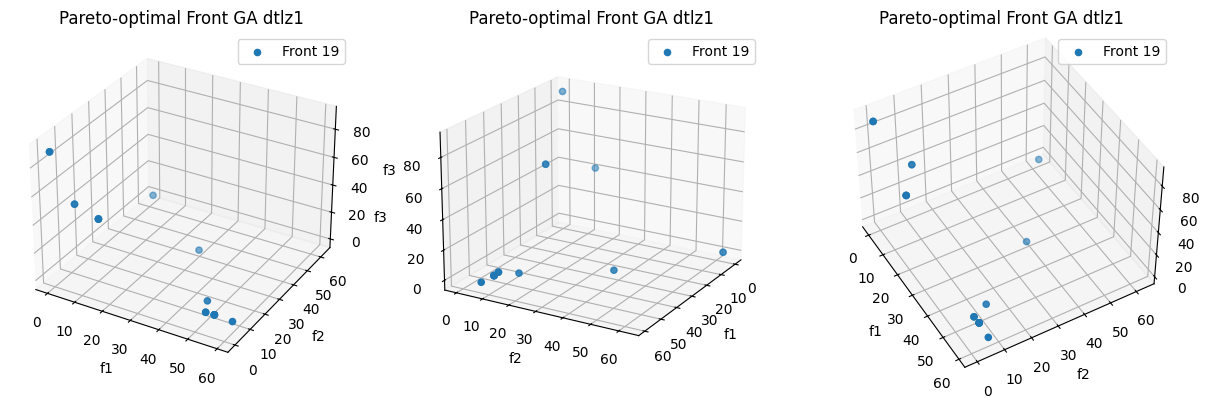

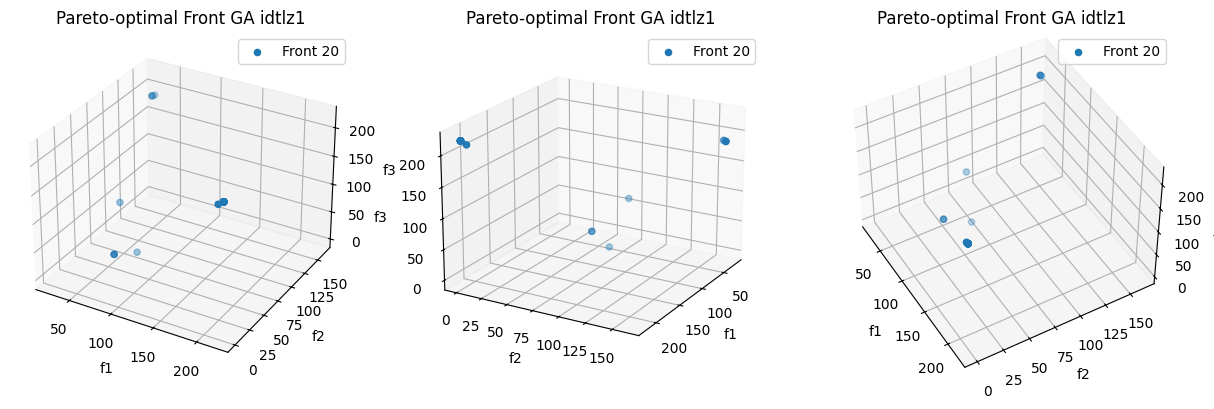

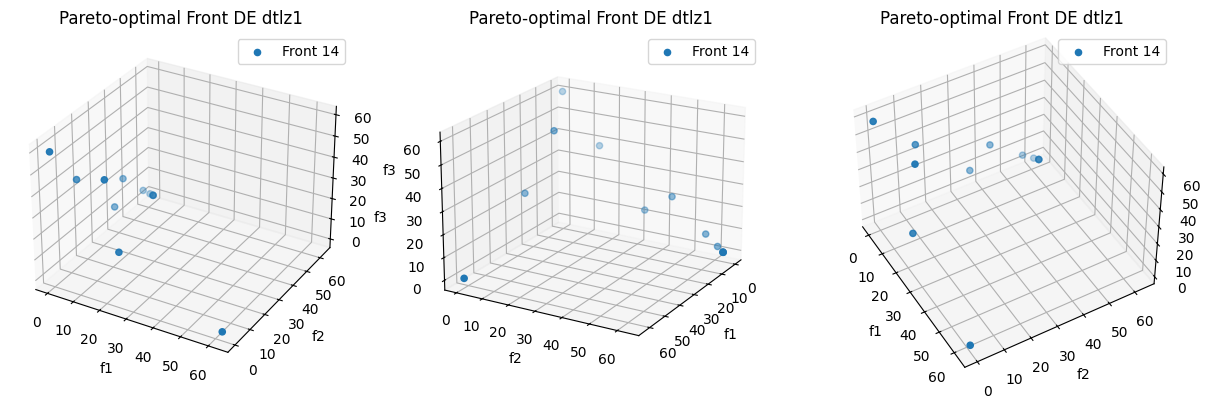

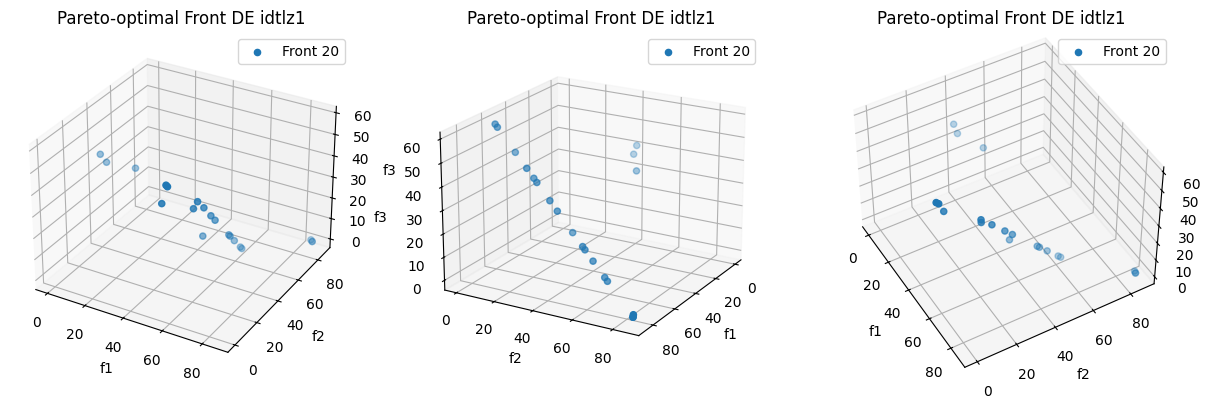

In [9]:
for key_alg in res:
    for problem in all_porb:
        i = res[key_alg][problem.name]
        
        plot_pareto_front_3d(results[key_alg][problem.name][i], problem.evaluate, title="Pareto-optimal Front "+ key_alg+' '+problem.name, labels=['f1','f2','f3'])
